# Установка необходимых пакетов
Запускать в случае работы на локальном ПК в окружении Anaconda (единожды)

In [0]:
import tensorflow as tf
import keras
import matplotlib as mpt
import cv2
import pandas as pd
import numpy as np
import math

Using TensorFlow backend.


# Загрузка аннотаций
Здесь откройте файл с аннотациями и считайте все данные

Формат аннотаций:

имя_файла upper_face_corner_x upper_face_corner_y bottom_face_corner_x bottom_face_corner_y left_eye_x left_eye_y right_eye_x right_eye_y nose_x nose_y left_mouth_x left_mouth_y right_mouth_x right_mouth_y

Координаты левого верхнего и правого нижнего углов описывающего прямоугольника заданы относительно изображения. Координаты лэндмарок - относительно описывающего прямоугольника

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
def load_annotations():
    annotations = pd.read_csv('/content/drive/My Drive/Macroscop test/annotations.txt', 
                              sep=" ", header=None)
    annotations.columns = ["file_name", "upper_face_corner_x", "upper_face_corner_y", 
                           "bottom_face_corner_x", "bottom_face_corner_y", "left_eye_x", 
                           "left_eye_y", "right_eye_x", "right_eye_y", "nose_x", "nose_y", 
                           "left_mouth_x", "left_mouth_y", "right_mouth_x", "right_mouth_y","blank"]
    del annotations['blank'] # Удаление лишних пробелов в конце строк в файле
    return annotations

  
annotations = load_annotations()

# Отображение изображений
Здесь загрузите и отобразите все изображения. Рекомендуется использовать реализованный метод отображения.

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline 
from keras.preprocessing.image import load_img,img_to_array


def load_img_from_file(annotations):
    img_path = '/content/drive/My Drive/Macroscop test/images/'
    img_array = []
    for img_name in annotations['file_name']:
        img = cv2.imread(img_path + img_name)
        img_array.append(img)
    return img_array

In [0]:
def show_images(images):
    '''
    Функция для ин-лайн отображения изображений
    Входные параметры:
    images: массив изображений в формате BGR
    '''
    columns = 2
    images_count = len(images)    
    
    for i, image in enumerate(images):
        plt.figure(figsize=(15,40))
        plt.subplot(images_count / columns + 1, columns, i + 1)
        image = image / 255
        print(str(i) + '.jpg')
        plt.imshow(image[:,:,::-1])
        plt.show()

0.jpg


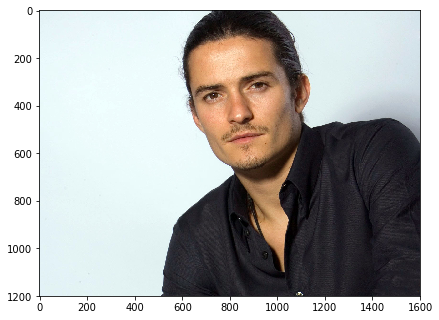

1.jpg


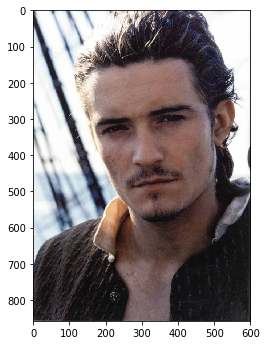

2.jpg


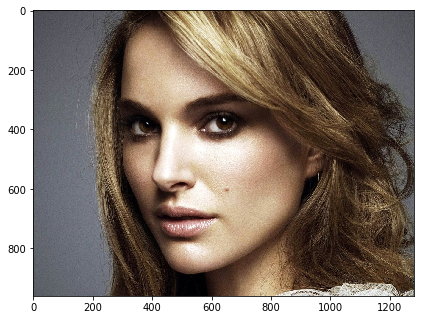

3.jpg


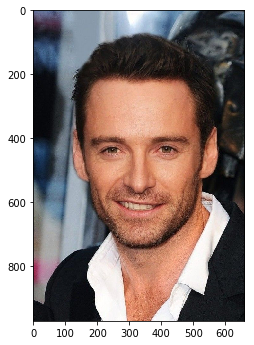

4.jpg


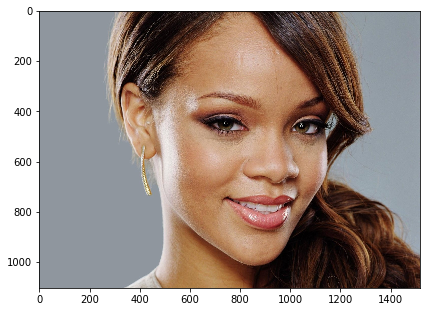

5.jpg


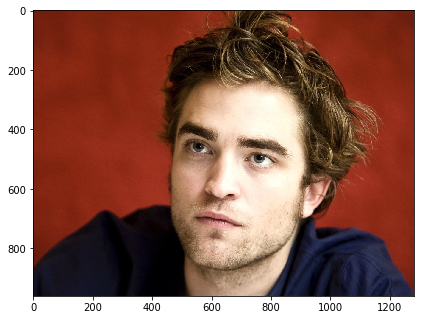

6.jpg


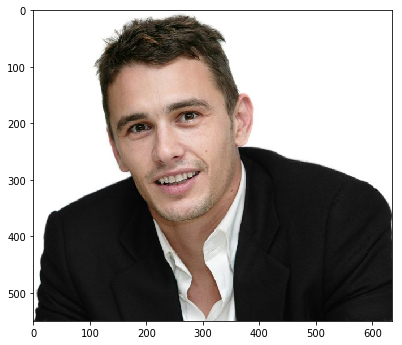

7.jpg


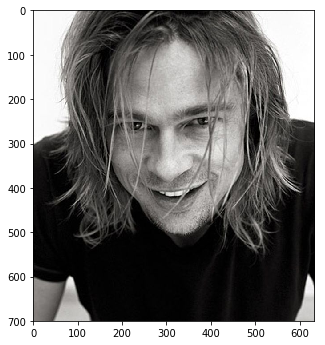

8.jpg


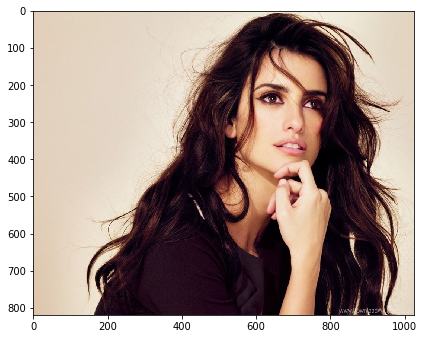

9.jpg


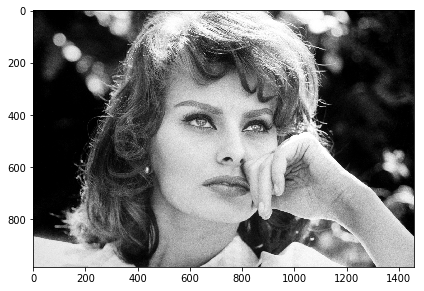

In [0]:
images = load_img_from_file(annotations)
show_images(images)

# Отображение рамок лиц и лэндмарок
Здесь отобразите изображения с нарисованными рамками и лэндмарками

In [0]:
def int_round(num):
    return int(round(num))
  
  
def dot_calc(src_arr, obj_name, corner_bottom, corner_up,i):
    dot = (corner_bottom - corner_up) * src_arr[obj_name][i] + corner_up
    return dot
  
  
def dot_show(src_arr, img, x_obj_name, y_obj_name, x_corner_bottom, 
             x_corner_up, y_corner_bottom, y_corner_up,i):
    x_obj = dot_calc(src_arr, x_obj_name, x_corner_bottom, x_corner_up,i)
    y_obj = dot_calc(src_arr, y_obj_name, y_corner_bottom, y_corner_up,i)
    return cv2.circle(img, (int_round(x_obj), int_round(y_obj)), 1, (0, 255, 0), 7)

0.jpg


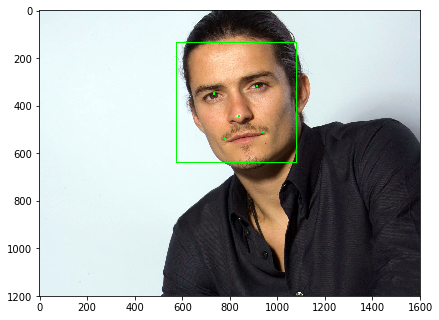

1.jpg


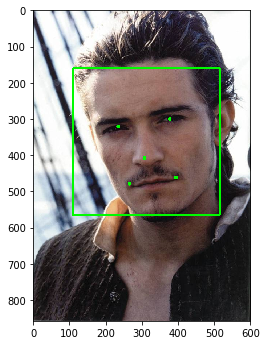

2.jpg


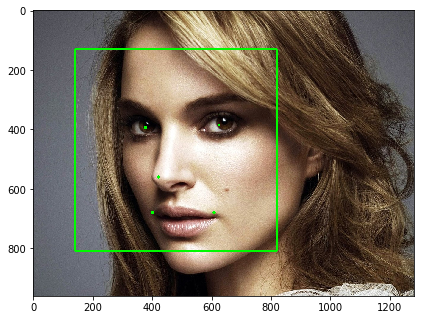

3.jpg


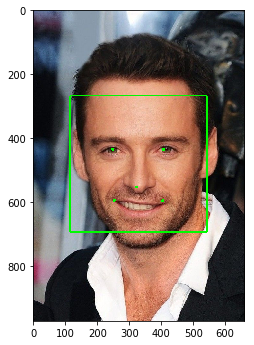

4.jpg


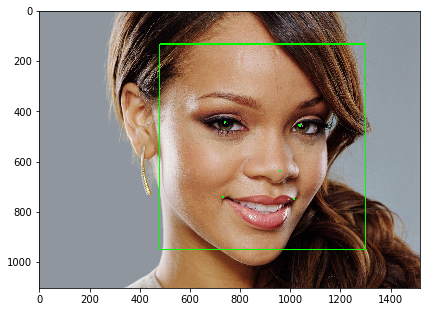

5.jpg


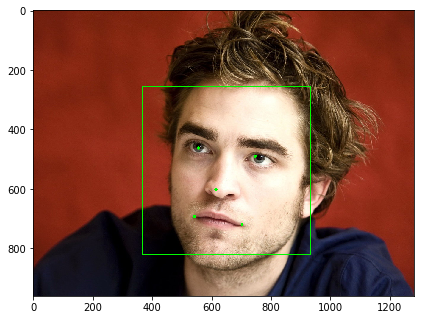

6.jpg


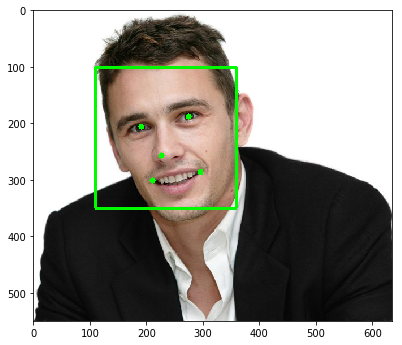

7.jpg


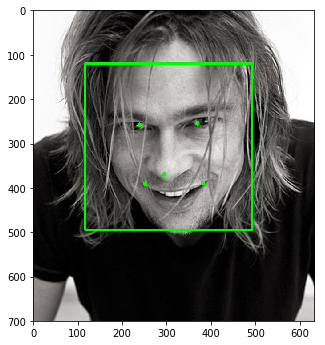

8.jpg


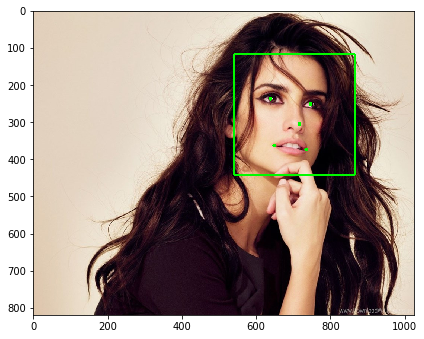

9.jpg


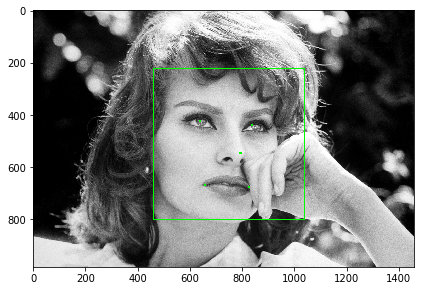

In [0]:
def draw_all_and_show_images(images, src_arr):
    '''
    Функция для нанесения лэндмарок на изображения
    Входные параметры:
    images: массив изображений в формате BGR
    '''
    img_array = []
    i = 0
    for img in images:
        # Рисуем рамку для лица
        x_corner_up = src_arr['upper_face_corner_x'][i] * img.shape[1]
        y_corner_up = src_arr['upper_face_corner_y'][i] * img.shape[0]
        x_corner_bottom = src_arr['bottom_face_corner_x'][i] * img.shape[1]
        y_corner_bottom = src_arr['bottom_face_corner_y'][i] * img.shape[0]
        img_mod = cv2.rectangle(img, (int_round(x_corner_up), int_round(y_corner_up)), 
                                (int_round(x_corner_bottom), int_round(y_corner_bottom)),
                                (0, 250, 0),  3)
        # Рисуем лэндмарки
        img_mod = dot_show(src_arr, img_mod, 'left_eye_x', 'left_eye_y',
                           x_corner_bottom, x_corner_up, y_corner_bottom, y_corner_up, i)
        img_mod = dot_show(src_arr,img_mod, 'right_eye_x', 'right_eye_y', 
                           x_corner_bottom, x_corner_up, y_corner_bottom, y_corner_up, i)        
        img_mod = dot_show(src_arr, img_mod, 'nose_x', 'nose_y', 
                           x_corner_bottom, x_corner_up, y_corner_bottom, y_corner_up, i)        
        img_mod = dot_show(src_arr, img_mod, 'left_mouth_x', 'left_mouth_y',
                           x_corner_bottom, x_corner_up, y_corner_bottom, y_corner_up, i)        
        img_mod = dot_show(src_arr,img_mod, 'right_mouth_x', 'right_mouth_y',
                           x_corner_bottom, x_corner_up, y_corner_bottom, y_corner_up, i)      
        img_array.append(img_mod)
        i = i + 1
    return img_array
    
    
images_rect = draw_all_and_show_images(images, annotations)
show_images(images_rect)

# Наложение модели очков
Здесь реализуйте автоматическое наложение очков на лица на основании ключевых точек (лэндмарок) и отобразите

In [0]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result


def glasses_calc_x(x_corner_bottom, x_corner_up, src_arr, i):
    x_coef = 6
    glasses_dot = int(dot_calc(src_arr, 'left_eye_x', x_corner_bottom, x_corner_up, i) - 
                     (x_corner_bottom - x_corner_up) / x_coef)
    return glasses_dot 

  
def glasses_calc_y(y_corner_bottom, y_corner_up, src_arr, i):
    y_coef = 7
    glasses_dot = int(dot_calc(src_arr, 'left_eye_x', y_corner_bottom, y_corner_up, i) - 
                     (y_corner_bottom - y_corner_up) / y_coef)
    return glasses_dot 
  
  
def rotate_angle_calc(y_left, y_right, x_right, x_left):
    rotate_angle = math.atan(math.fabs(y_left - y_right) / (x_right - x_left)) * 57.296
    if (y_left < y_right):
        rotate_angle = -1 * rotate_angle
    return rotate_angle

0.jpg


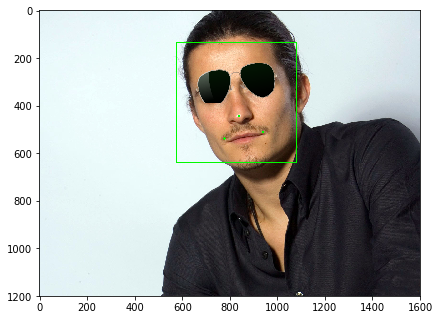

1.jpg


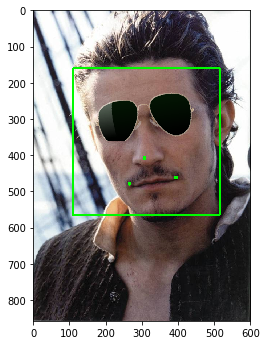

2.jpg


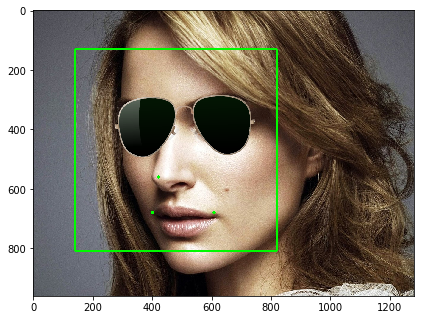

3.jpg


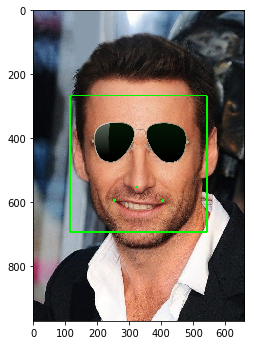

4.jpg


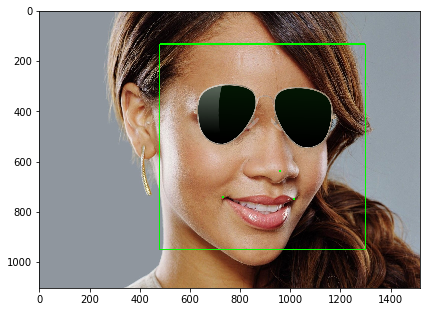

5.jpg


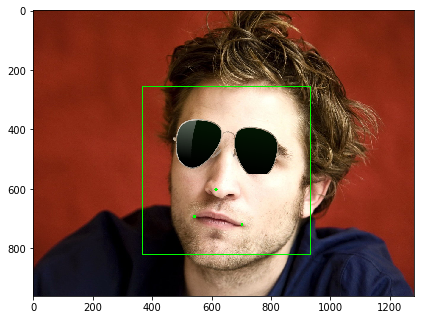

6.jpg


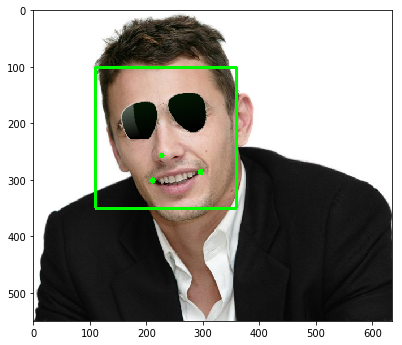

7.jpg


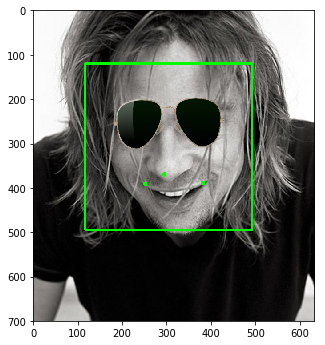

8.jpg


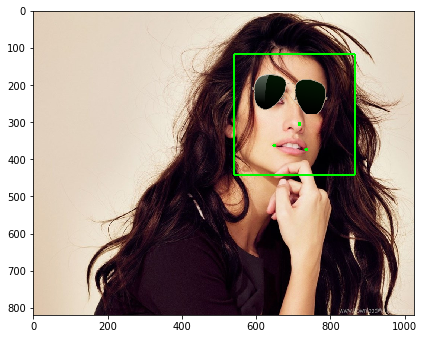

9.jpg


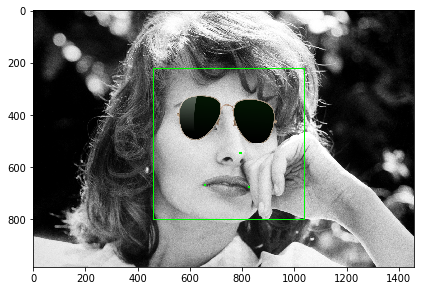

In [0]:
def add_glasses_and_show_images(src_arr, images):
    '''
    Функция для наложения очков на фотографию лица по лэндмаркам
    Входные параметры:
    images: массив изображений в формате BGR
    '''
    img_array = []
    i = 0
    img_glasses_path = '/content/drive/My Drive/Macroscop test/glasses.png'
    img_glasses = cv2.imread(img_glasses_path, cv2.IMREAD_UNCHANGED)
    
    for img in images:
        x_corner_up = src_arr['upper_face_corner_x'][i] * img.shape[1]
        y_corner_up = src_arr['upper_face_corner_y'][i] * img.shape[0]
        x_corner_bottom = src_arr['bottom_face_corner_x'][i] * img.shape[1]
        y_corner_bottom = src_arr['bottom_face_corner_y'][i] * img.shape[0]
        x_left_eye = dot_calc(src_arr, 'left_eye_x', x_corner_bottom, x_corner_up, i) 
        x_right_eye = dot_calc(src_arr, 'right_eye_x', x_corner_bottom, x_corner_up, i)
        y_left_eye = dot_calc(src_arr, 'left_eye_y', y_corner_bottom, y_corner_up, i)
        y_right_eye = dot_calc(src_arr, 'right_eye_y', y_corner_bottom, y_corner_up, i)
        
        # Обработка изображения очков
        img_glasses2 = cv2.resize(img_glasses,(int((x_right_eye - x_left_eye) * 2), 
                                               int_round((y_corner_bottom-y_corner_up) / 3)))      
        rotate_angle = rotate_angle_calc(y_left_eye, y_right_eye, x_right_eye, x_left_eye)
        img_glasses2 = rotate_image(img_glasses2,rotate_angle)                 
        
        # Формируем область, на которую будут наложены очки. Складываем область в img_bg
        rows,cols,channels = img_glasses2.shape
        roi = img[glasses_calc_y(y_corner_bottom, y_corner_up, src_arr, i): 
                  glasses_calc_y(y_corner_bottom, y_corner_up, src_arr, i) + rows, 
                  glasses_calc_x(x_corner_bottom, x_corner_up, src_arr, i):
                  glasses_calc_x(x_corner_bottom, x_corner_up, src_arr, i) + cols]        
        img2gray = cv2.cvtColor(img_glasses2, cv2.COLOR_BGR2GRAY)
        ret, mask = cv2.threshold(img2gray, 255, 255, cv2.THRESH_BINARY)
        mask_inv = cv2.bitwise_not(mask)
        img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
        
        # Формируем прозрачный фон (для openCV), складываем фон в overlay_img и маску в overlay_mask
        overlay_img = img_glasses2[:,:,:3]              
        overlay_mask = img_glasses2[:,:,3:]             
        background_mask = 255 - overlay_mask
        overlay_mask = cv2.cvtColor(overlay_mask, cv2.COLOR_GRAY2BGR)
        background_mask = cv2.cvtColor(background_mask, cv2.COLOR_GRAY2BGR)
        
        # Складываем область наложения и очки вместе, затем заменяем ею область на полном фото
        face_part = (img_bg * (1 / 255.0)) * (background_mask * (1 / 255.0))
        overlay_part = (overlay_img * (1 / 255.0)) * (overlay_mask * (1 / 255.0))        
        dst_glasses = cv2.addWeighted(face_part, 255.0, overlay_part, 255.0, 0.0)      
        img[glasses_calc_y(y_corner_bottom, y_corner_up, src_arr, i): 
            glasses_calc_y(y_corner_bottom, y_corner_up, src_arr, i) + rows, 
            glasses_calc_x(x_corner_bottom, x_corner_up, src_arr, i): 
            glasses_calc_x(x_corner_bottom, x_corner_up, src_arr, i) + cols] = dst_glasses
        img_array.append(img)
        i = i + 1
    return img_array
    
    
imagges_glasses = add_glasses_and_show_images(annotations, images)
show_images(imagges_glasses)